In [88]:
import torch
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

In [89]:
ft_epochs = torch.arange(4, 100, 5)
abs_distances_pre: torch.Tensor = torch.load('./trained_models/distances_solid_absolute_pre.pt', map_location='cpu')
abs_distances_ft: torch.Tensor = [
    torch.load(f'./trained_models/distances_solid_absolute_{i}.pt', map_location='cpu')
    for i in ft_epochs
]
abs_distances_pre.size()
ft_epochs

tensor([ 4,  9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89,
        94, 99])

In [90]:
print(len(abs_distances_pre))

5000


In [91]:
distance_buckets = [0.01, 0.001]
delta_mems = {delta : torch.sum(abs_distances_pre < delta) for delta in distance_buckets}
delta_mems

{0.01: tensor(163), 0.001: tensor(24)}

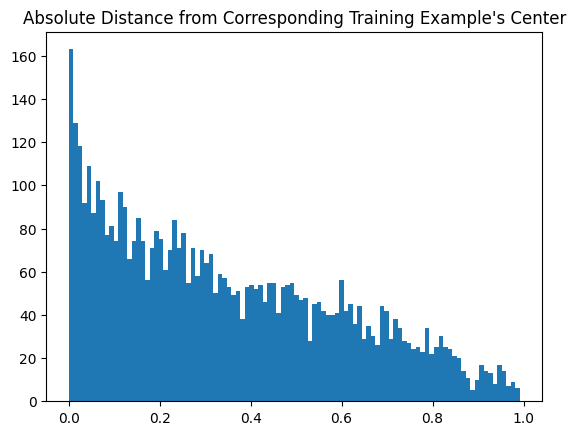

In [92]:
plt.hist(abs_distances_pre, bins=100)
plt.title("Absolute Distance from Corresponding Training Example's Center")
plt.show()

In [93]:
abs_distances_pre = abs_distances_pre[abs_distances_pre < 0.01]
abs_distances_pre.size()

torch.Size([163])

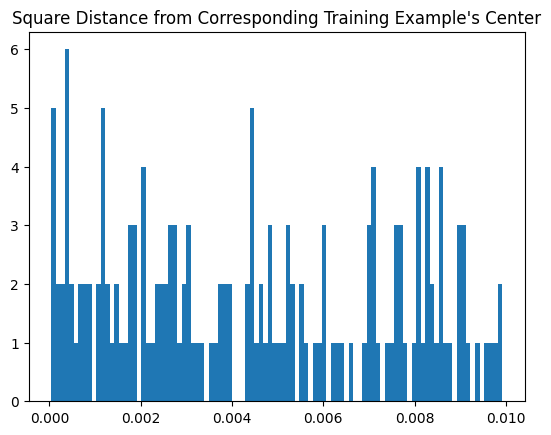

In [94]:
plt.hist(abs_distances_pre, bins=100)
plt.title("Square Distance from Corresponding Training Example's Center")
plt.show()

In [95]:
ft_epochs = torch.cat((torch.tensor([0]), ft_epochs))
abs_distances_ft = [abs_distances_pre] + abs_distances_ft
accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_{epoch}_0.001.pt', map_location='cpu') for epoch in ft_epochs])

In [96]:
buckets_per_ft = [
    [sum(distance < bucket) for distance in abs_distances_ft]
    for bucket in distance_buckets
]

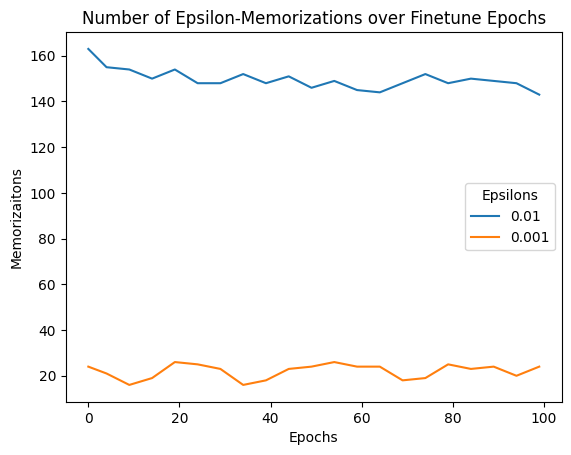

In [97]:
for i, bucket in enumerate(distance_buckets):
    plt.plot(ft_epochs, buckets_per_ft[i], label=bucket)
plt.legend(title="Epsilons")
plt.title("Number of Epsilon-Memorizations over Finetune Epochs")
plt.xlabel("Epochs")
plt.ylabel("Memorizaitons")
plt.show()

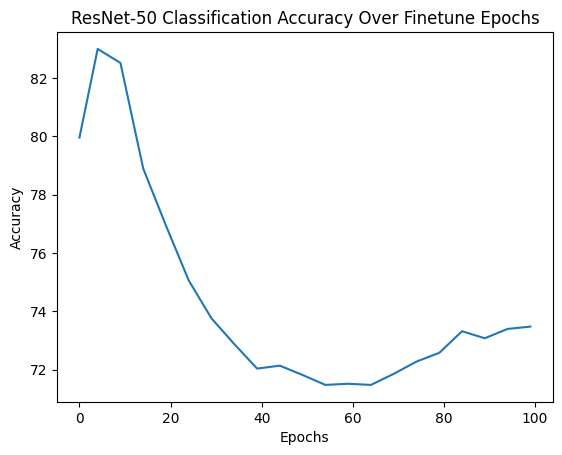

In [98]:
plt.plot(ft_epochs, accuracies)
plt.title("ResNet-50 Classification Accuracy Over Finetune Epochs")
plt.ylabel('Accuracy')
plt.xlabel("Epochs")
plt.show() 

In [99]:
ft_epochs = torch.arange(2, 22, 2)
mnist_epoch: int = 49 # MNIST Epoch - 1, so zero would be one epoch of FT
baseline_distances: torch.Tensor = abs_distances_pre
baseline_accuracy = accuracies[0]
abs_distances_ft: list[torch.Tensor] = [
    torch.load(f'./trained_models/distances_solid_absolute_mnist_{mnist_epoch}_{epoch}.pt', map_location='cpu')
    for epoch in ft_epochs
]
accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_mnist_{mnist_epoch}_{epoch}.pt', map_location='cpu') for epoch in ft_epochs])
abs_distances_pre.size()
ft_epochs

tensor([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])

In [100]:
buckets_per_ft = [
    [sum(distance < bucket) for distance in abs_distances_ft]
    for bucket in distance_buckets
]
baseline_buckets = [sum(baseline_distances < bucket) for bucket in distance_buckets]

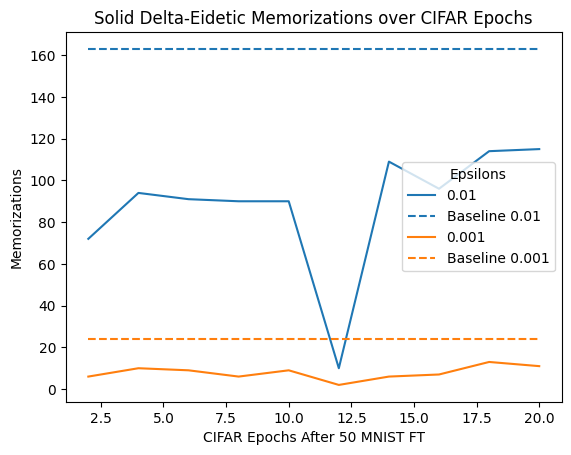

In [101]:
ax: Axes = plt.gca()
for i, bucket in enumerate(distance_buckets):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(ft_epochs, buckets_per_ft[i], label=bucket, color=color)
    plt.plot(ft_epochs, [baseline_buckets[i] for _ in ft_epochs], '--', label=f"Baseline {bucket}", color=color)
plt.legend(title="Epsilons")
plt.title("Solid Delta-Eidetic Memorizations over CIFAR Epochs")
plt.xlabel(f"CIFAR Epochs After {mnist_epoch + 1} MNIST FT")
plt.ylabel("Memorizations")
plt.show()

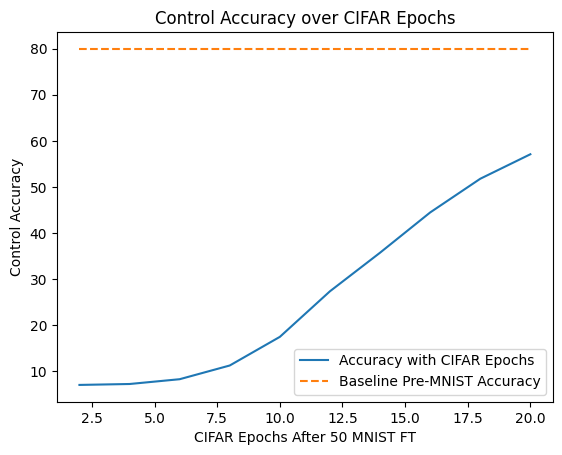

In [102]:
plt.plot(ft_epochs, accuracies, label="Accuracy with CIFAR Epochs")
plt.plot(ft_epochs, [baseline_accuracy for _ in ft_epochs], '--', label="Baseline Pre-MNIST Accuracy")
plt.title("Control Accuracy over CIFAR Epochs")
plt.xlabel(f"CIFAR Epochs After {mnist_epoch + 1} MNIST FT")
plt.ylabel("Control Accuracy")
plt.legend()
plt.show()

In [103]:
mnist_epochs = torch.arange(0, 50)
mnist_accuracies: torch.Tensor = torch.tensor([torch.load(f'./trained_models/accuracy_mnist_epoch_{epoch}.pt', map_location='cpu') for epoch in mnist_epochs])

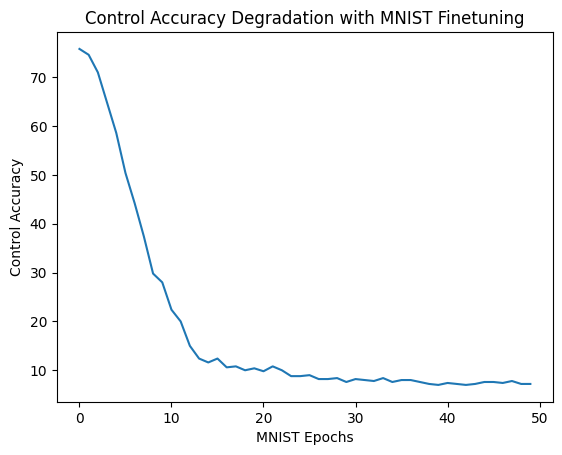

In [104]:
plt.plot(mnist_epochs, mnist_accuracies)
plt.xlabel("MNIST Epochs")
plt.ylabel("Control Accuracy")
plt.title("Control Accuracy Degradation with MNIST Finetuning")
plt.show()

In [105]:
gaussian_perturbs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
gaussian_distances: list[torch.Tensor] = [baseline_distances] + [
    torch.load(f'./trained_models/distances_solid_absolute_perturb_{i}.pt', map_location='cpu')
    for i in gaussian_perturbs
]
gaussian_perturbs = [0] + gaussian_perturbs
buckets_per_perturb = [
    [sum(distance < bucket) for distance in gaussian_distances]
    for bucket in distance_buckets
]

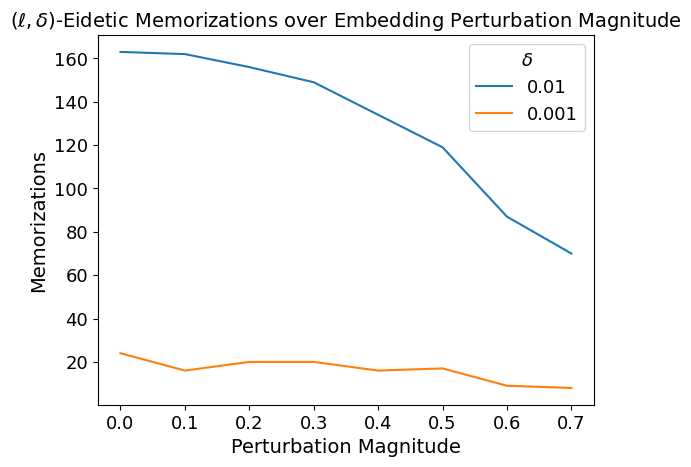

In [106]:
for i, bucket in enumerate(distance_buckets):
    plt.plot(gaussian_perturbs, buckets_per_perturb[i], label=bucket)
leg = plt.legend(title="$\delta$", fontsize=13)
plt.setp(leg.get_title(),fontsize=13)
plt.title("$(\ell, \delta)$-Eidetic Memorizations over Embedding Perturbation Magnitude", fontsize=14)
plt.xlabel("Perturbation Magnitude", fontsize=14)
plt.ylabel("Memorizations", fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [107]:
gaussian_perturbs = torch.arange(10)
gaussian_distances: list[torch.Tensor] = [
    torch.load(f'./trained_models/distances_sd_5k_gaussian_{i}.pt', map_location='cpu')
    for i in gaussian_perturbs
]
buckets_per_perturb = [
    [sum(distance < bucket) for distance in gaussian_distances]
    for bucket in distance_buckets
]
print(buckets_per_perturb[0])

[tensor(806), tensor(823), tensor(790), tensor(762), tensor(694), tensor(706), tensor(681), tensor(670), tensor(665), tensor(688)]


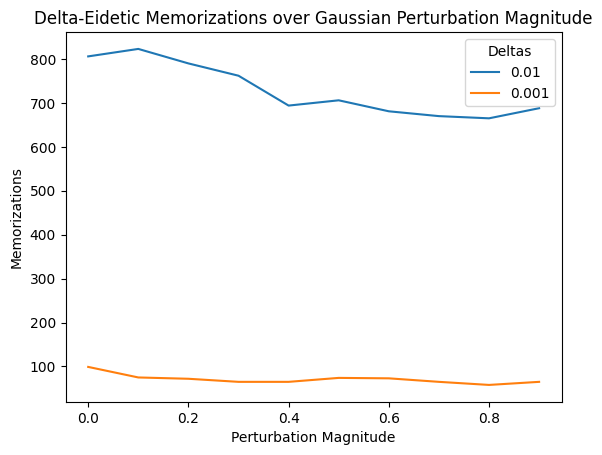

In [108]:
for i, bucket in enumerate(distance_buckets):
    plt.plot(gaussian_perturbs / 10, buckets_per_perturb[i], label=bucket)
plt.legend(title="Deltas")
plt.title("Delta-Eidetic Memorizations over Gaussian Perturbation Magnitude")
plt.xlabel("Perturbation Magnitude")
plt.ylabel("Memorizations")
plt.show()

In [109]:
def plot_technique(perturbs: torch.Tensor, name: str, buckets: list[int]):
    distances: list[torch.Tensor] = [
    torch.load(f'./trained_models/distances_sd_5k_{name}_{i}.pt', map_location='cpu')
    for i in perturbs
    ]
    buckets_per_perturb = [
        [sum(distance < bucket) for distance in distances]
        for bucket in buckets
    ]
    print(buckets_per_perturb[0])
    for i, bucket in enumerate(distance_buckets):
        plt.plot(perturbs, buckets_per_perturb[i], label=bucket)
        plt.legend(title="Deltas")
        plt.title(f"Delta-Eidetic Memorizations over {name} Mitigation Strength")
        plt.xlabel("Mitigation Strength")
        plt.ylabel("Memorizations")
    plt.show()

[tensor(830), tensor(844), tensor(796), tensor(777), tensor(812), tensor(785), tensor(772), tensor(826), tensor(804), tensor(797)]


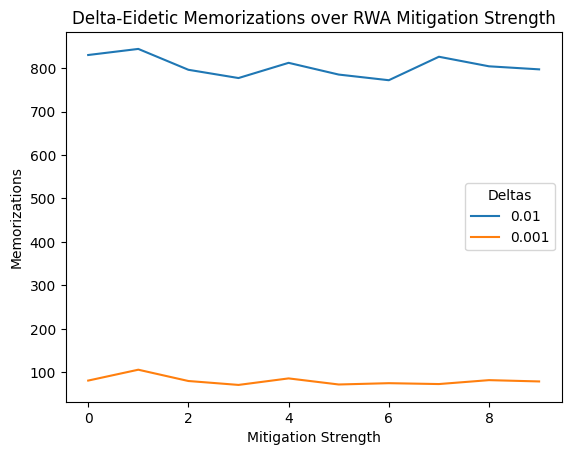

In [110]:
plot_technique(torch.arange(10), "RWA", distance_buckets)

[tensor(824), tensor(794), tensor(802), tensor(836), tensor(874), tensor(842), tensor(822), tensor(832), tensor(762), tensor(795)]


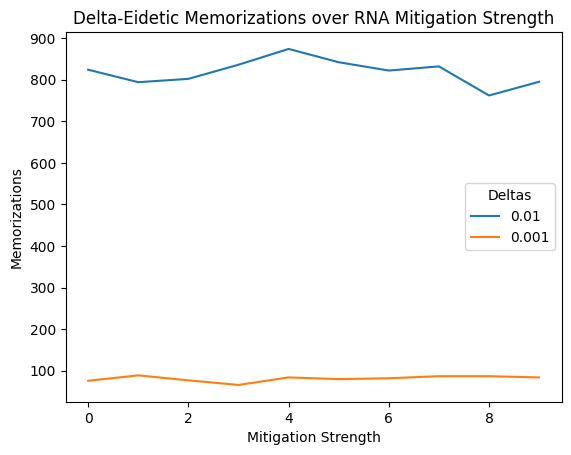

In [111]:
plot_technique(torch.arange(10), "RNA", distance_buckets)

[tensor(806), tensor(804), tensor(776), tensor(814), tensor(850), tensor(812), tensor(845), tensor(799), tensor(854), tensor(831)]


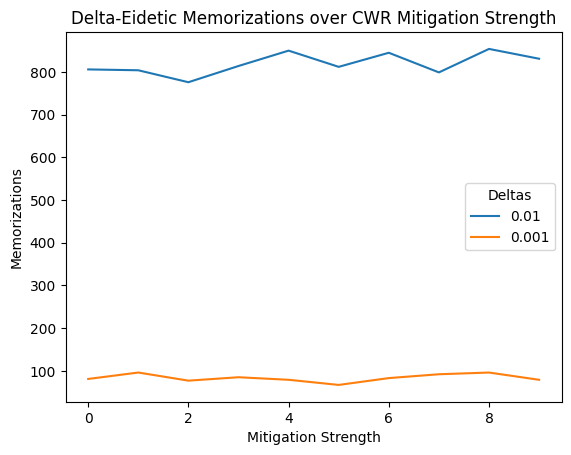

In [112]:
plot_technique(torch.arange(10), "CWR", distance_buckets)